# Exemplo de análise de agrupamentos



In [1]:
################################################################################
# Definindo um caminho personalizado para bibliotecas R
################################################################################
# Exemplo de caminho: pode ser uma pasta dentro do seu diretório home
# Lembre-se que o R pode adicionar subdiretórios específicos da versão/arquitetura
meu_caminho_biblioteca <- "~/R/library"

# Define a variável de ambiente R_LIBS_USER para a sessão atual
Sys.setenv(R_LIBS_USER = meu_caminho_biblioteca)

# Verifica o valor da variável de ambiente
Sys.getenv("R_LIBS_USER")

# Mostra todos os caminhos de biblioteca que o R está usando
# O seu novo caminho deve aparecer aqui, geralmente como o primeiro da lista.
.libPaths()

[1] "~/R/library"

[1] "/usr/local/lib/R/site-library" "/usr/local/lib/R/library"     
[3] "/home/vscode/R/library"

In [2]:
################################################################################
#               INSTALAÇÃO E CARREGAMENTO DE PACOTES NECESSÁRIOS               #
################################################################################

# Pacotes utilizados
pacotes <- c("tidyverse", #carregar outros pacotes do R
             "knitr", "kableExtra", #formatação de tabelas
             "arrow","duckdb", # parquet e banco de dados
             "factoextra", "pheatmap") # visualização de agrupamentos

if(sum(as.numeric(!pacotes %in% installed.packages())) != 0){
  instalador <- pacotes[!pacotes %in% installed.packages()]
  for(i in 1:length(instalador)) {
    install.packages(instalador, dependencies = T, lib = meu_caminho_biblioteca)
    break()}
  sapply(pacotes, require, character = T, lib = meu_caminho_biblioteca) 
} else {
  sapply(pacotes, require, character = T, lib = meu_caminho_biblioteca) 
}

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: knitr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘knitr’”
Loading required package: kableExtra


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


Loading required package: arrow


Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

 

tidyverse      knitr kableExtra      arrow     duckdb factoextra   pheatmap 
      TRUE      FALSE       TRUE       TRUE       TRUE       TRUE       TRUE

## Exemplo inicial didático retirado de:

https://www.datanovia.com/en/lessons/cluster-analysis-example-quick-start-r-code/

In [3]:
library(cluster)
library(factoextra)

In [4]:
# https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests
mydata <- scale(USArrests)

In [ ]:
# Listar os dados dessa tabela mydata
# valores por 100.000 habitantes
head(mydata)

,Murder,Assault,UrbanPop,Rape
Alabama,1.24256408,0.7828393,-0.5209066,-0.003416473
Alaska,0.50786248,1.1068225,-1.2117642,2.484202941
Arizona,0.07163341,1.4788032,0.9989801,1.042878388
Arkansas,0.23234938,0.2308680,-1.0735927,-0.184916602
California,0.27826823,1.2628144,1.7589234,2.067820292
Colorado,0.02571456,0.3988593,0.8608085,1.864967207


Os valores negativos são valores **padronizados (z‑scores)** do dataset `USArrests` depois de passar pela função `scale()` em R.

## O que é o USArrests “original”

No conjunto original `USArrests`, as colunas são:  
- `Murder`: prisões por homicídio por 100.000 habitantes  
- `Assault`: prisões por assalto por 100.000 habitantes  
- `UrbanPop`: porcentagem da população que vive em áreas urbanas  
- `Rape`: prisões por estupro por 100.000 habitantes

Todos esses valores são **não negativos** no dataset bruto: taxas por 100.000 habitantes e porcentagens entre 0 e 100.

## O que a função scale() faz

Quando aplicamos algo como:

```r
USArrests.scaled <- scale(USArrests)
```

R faz, para cada variável \(X\):

\[
Z = \frac{X - \bar{X}}{s_X}
\]

subtraindo a média \(\bar{X}\) e dividindo pelo desvio padrão \(s_X\).[5][3]

- A nova variável `Z` tem média 0 e desvio padrão 1.[3][5]
- Valores acima da média viram **positivos** (ex.: 1.2 = 1,2 desvios‑padrão acima da média).  
- Valores abaixo da média viram **negativos** (ex.: −0.52 = 0,52 desvios‑padrão abaixo da média).

Exemplos:

- Alabama: `UrbanPop = -0.5209066` → Alabama tem porcentagem urbana **menor que a média dos estados**.  
- Alaska: `Rape = 2.484202941` → Alaska tem taxa de prisões por estupro **bem acima da média**, cerca de 2,48 desvios‑padrão.[6]

## Como interpretar na prática

Pense numa rodovia com velocidade média 80 km/h e desvio‑padrão 10 km/h.  
- Um carro a 90 km/h está em \( (90−80)/10 = 1 \) desvio‑padrão acima da média → valor padronizado +1.  
- Um carro a 70 km/h está em \( (70−80)/10 = -1 \) desvio‑padrão → valor padronizado −1.

O que você está vendo em `Murder`, `Assault`, `UrbanPop` e `Rape` é **a mesma ideia**, só que aplicada às variáveis de crime e urbanização dos estados:

- Negativo = estado abaixo da média dos EUA naquela variável.  
- Positivo = estado acima da média.  
- Valor em módulo grande (|z| > 2) = estado bem “extremo” naquela variável.

## Resumo em tabela

| Coluna    | No dado original (USArrests)                                   | Após `scale()` (sua matriz)                                          |
|-----------|----------------------------------------------------------------|-----------------------------------------------------------------------|
| Murder    | Prisões por homicídio por 100.000 habitantes (≥ 0)    | Z‑score: desvios‑padrão em relação à média de homicídios    |
| Assault   | Prisões por assalto por 100.000 habitantes (≥ 0)      | Z‑score de assalto                                           |
| UrbanPop  | Percentual da população em área urbana (0–100) | Z‑score da porcentagem urbana (podendo ser negativo) |
| Rape      | Prisões por estupro por 100.000 habitantes (≥ 0) | Z‑score da taxa de estupro (podendo ser negativo)    |

Para fixar: vale a pena rodar em R algo como `cbind(USArrests, scale(USArrests))` e comparar, estado a estado, os valores originais com os padronizados. Que estado você desconfia que seria bem acima da média em `Assault`? Quando você ver o z‑score, isso confirma sua intuição?


In [8]:
cbind(USArrests, scale(USArrests))

,Murder,Assault,UrbanPop,Rape,Murder,Assault,UrbanPop,Rape
,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alabama,13.2,236,58,21.2,1.24256408,0.78283935,-0.52090661,-0.003416473
Alaska,10.0,263,48,44.5,0.50786248,1.10682252,-1.21176419,2.484202941
Arizona,8.1,294,80,31.0,0.07163341,1.47880321,0.99898006,1.042878388
Arkansas,8.8,190,50,19.5,0.23234938,0.23086801,-1.07359268,-0.184916602
California,9.0,276,91,40.6,0.27826823,1.26281442,1.75892340,2.067820292
Colorado,7.9,204,78,38.7,0.02571456,0.39885929,0.86080854,1.864967207
Connecticut,3.3,110,77,11.1,-1.03041900,-0.72908214,0.79172279,-1.081740768
Delaware,5.9,238,72,15.8,-0.43347395,0.80683810,0.44629400,-0.579946294
Florida,15.4,335,80,31.9,1.74767144,1.97077766,0.99898006,1.138966691


In [6]:
summary(mydata)

     Murder           Assault           UrbanPop             Rape        
 Min.   :-1.6044   Min.   :-1.5090   Min.   :-2.31714   Min.   :-1.4874  
 1st Qu.:-0.8525   1st Qu.:-0.7411   1st Qu.:-0.76271   1st Qu.:-0.6574  
 Median :-0.1235   Median :-0.1411   Median : 0.03178   Median :-0.1209  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.: 0.7949   3rd Qu.: 0.9388   3rd Qu.: 0.84354   3rd Qu.: 0.5277  
 Max.   : 2.2069   Max.   : 1.9948   Max.   : 1.75892   Max.   : 2.6444  

In [7]:
str(mydata)

 num [1:50, 1:4] 1.2426 0.5079 0.0716 0.2323 0.2783 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:50] "Alabama" "Alaska" "Arizona" "Arkansas" ...
  ..$ : chr [1:4] "Murder" "Assault" "UrbanPop" "Rape"
 - attr(*, "scaled:center")= Named num [1:4] 7.79 170.76 65.54 21.23
  ..- attr(*, "names")= chr [1:4] "Murder" "Assault" "UrbanPop" "Rape"
 - attr(*, "scaled:scale")= Named num [1:4] 4.36 83.34 14.47 9.37
  ..- attr(*, "names")= chr [1:4] "Murder" "Assault" "UrbanPop" "Rape"


Determining the optimal number of clusters: use factoextra::fviz_nbclust()

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more informati

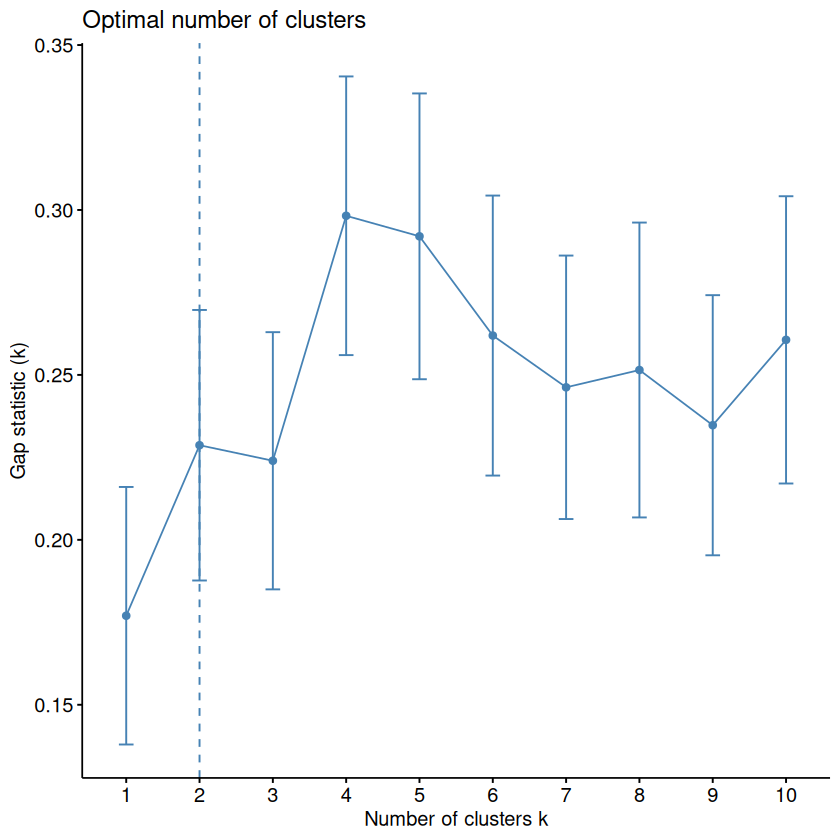

In [9]:
fviz_nbclust(mydata, kmeans, method = "gap_stat")

Compute and visualize k-means clustering:

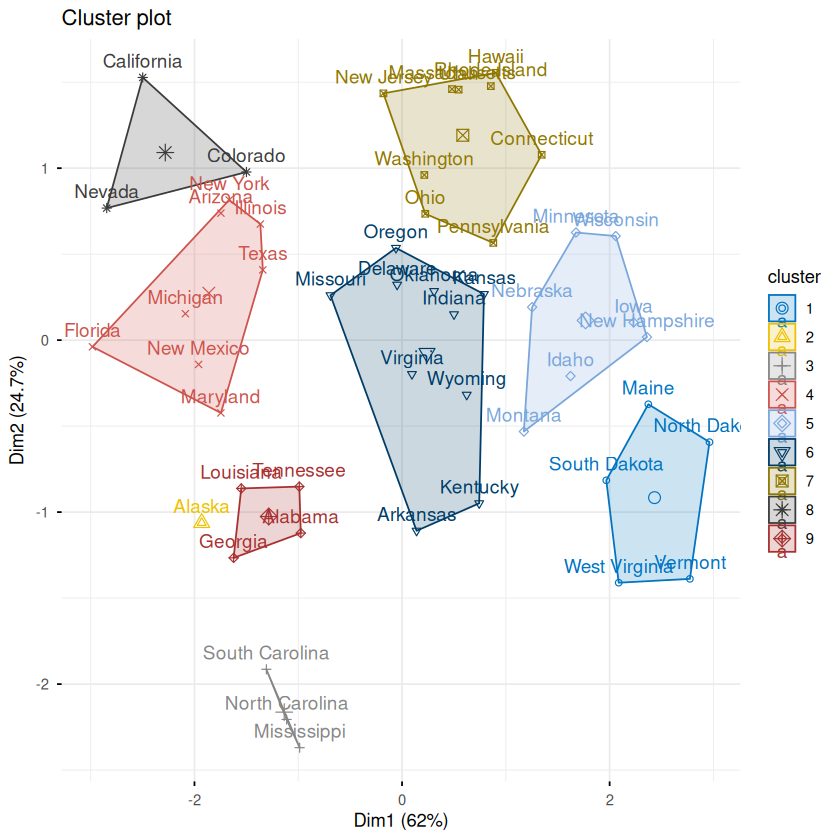

In [12]:
set.seed(123) # for reproducibility
# Sem set.seed() - resultados variam a cada execução
km.res <- kmeans(mydata, 9, nstart = 25)
# Visualize
fviz_cluster(km.res, data = mydata, palette = "jco",
             ggtheme = theme_minimal())

Hierarchical clustering
Hierarchical clustering is an alternative approach to partitioning clustering for identifying groups in the data set. It does not require to pre-specify the number of clusters to be generated.

The result of hierarchical clustering is a tree-based representation of the objects, which is also known as dendrogram. Observations can be subdivided into groups by cutting the dendrogram at a desired similarity level.

Computation: R function: hclust(). It takes a dissimilarity matrix as an input, which is calculated using the function dist().
Visualization: fviz_dend() [in factoextra]
R code to compute and visualize hierarchical clustering:

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the factoextra package.
  Please report the issue at <https://github.com/kassambara/factoextra/issues>.”


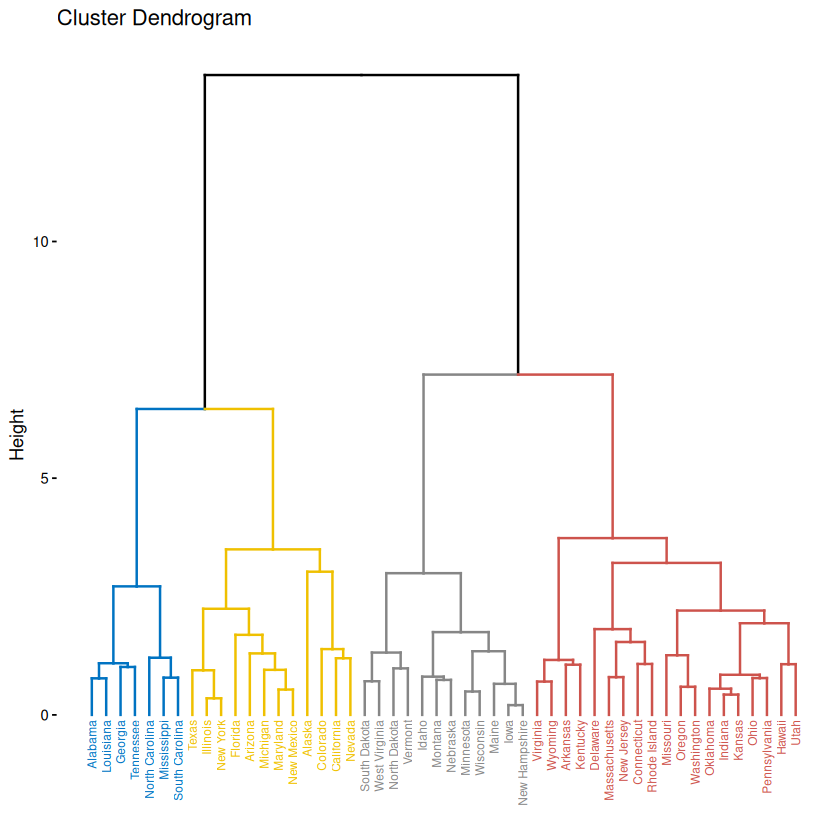

In [13]:
res.hc <- hclust(dist(mydata),  method = "ward.D2")
fviz_dend(res.hc, cex = 0.5, k = 4, palette = "jco") 

A heatmap is another way to visualize hierarchical clustering. It’s also called a false colored image, where data values are transformed to color scale. Heat maps allow us to simultaneously visualize groups of samples and features. You can easily create a pretty heatmap using the R package pheatmap.

In heatmap, generally, columns are samples and rows are variables. Therefore we start by transposing the data before creating the heatmap.

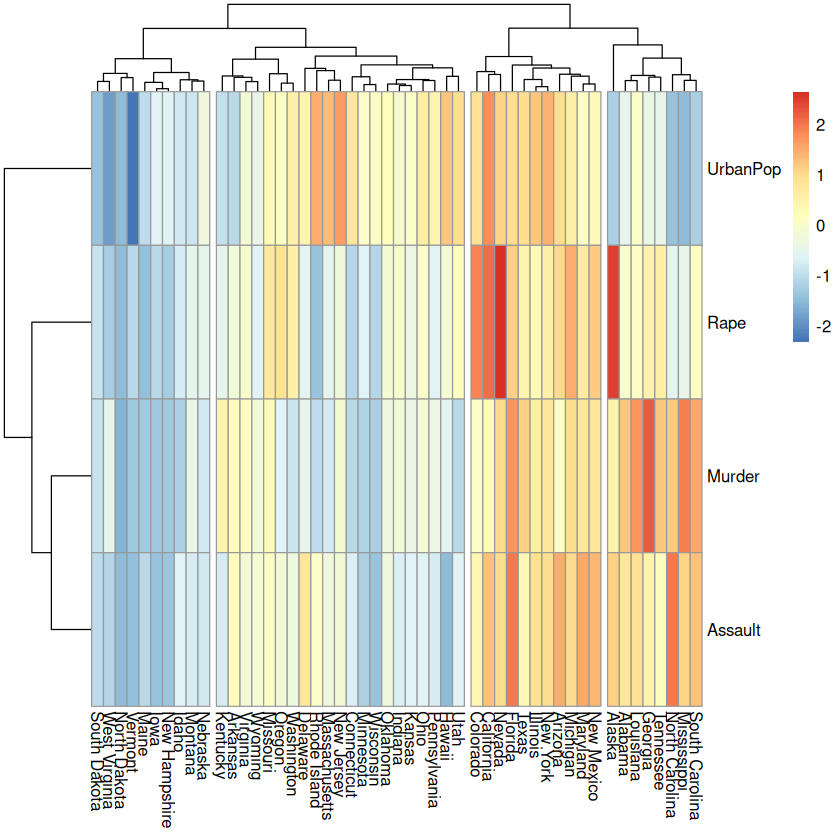

In [20]:
library(pheatmap)
pheatmap(t(mydata), cutree_cols = 4)